# Predicting Wins given a Final Stat Line
Similar to some of the previous NBA data models we will extract certain features and train a model.
Because I had trouble in small assignment 3 with training my model, I am electing to narrow the focus while also minimizing changes to data. This approach will show us if the next steps we take in future iterations/models are feasible.
### Steps
1. Gather and Transform Data
2. Train the Model
3. Test and Evaluate
4. Explore... Where can we improve in the future? What are the next steps?

##### Step 1. Gather and Transform Data
This is a very similar process to accessing other endpoints using the nba_api library. Here we are taking all of the games for a given season and taking each teams stat line.
There are about 1230 games in a season but we have 2460 (2 * 1230) because we are taking a team's stats from a game indepent of the matchup. I suspect that this will give us an easier (unknown) marker/threshhold for predicting an outcome (0 for loss. 1 for win). Additionally, we will designate a home team with 1 and away with 0. These are the only transformations done to the data in this iteration. In future models we may consider combining certain stats (i.e. 'fantasy points' through summing the good stats and substracting the bad stats).

##### Step 2. Train the Model
We are only using a subset of the columns provided by the dataset. These stats are the most common basic stats in NBA stats/analytics. I began training with only a few stats. After adding columns to a training data we notice significant improvements to our loss. At first when considering as little as 3 columns our loss was in the range of .6-.7. A couple more and we converge to .5. When considering all columns we converge to .3. One interesting things that happened was the loss not decreasing maybe 1 in 6 times training on the final training set. What can we learn from incorporating advanced stats in the future (like Offensive and Defensive Rating or Points per 100 possessions?) These stats are more so cumulative/aggregated. One I nail down TFT or training with time-series data, we can begin to develop a much more convaluted model. Is this necessary given our success? What would be the next step in developing an ensemble model?

##### Step 3. Test and Evaluate
There are several ways to evaluate our model and looking at all the ways brings me personal peace of mind. These results are not a fluke! Is it worth it to mess with the number of layers or nodes or the learning rate?

##### Step 4. Explore
I am curious about what the use cases for such a model could be. I suspect the next thing to do is consider the individual stats of players in a line up. How can we use this historical information to predict future outcomes? What are the effects of trades? How are players impacting each others' performances? Can we predict how far into the postseason a team makes it? One thought I had revolves conceptually thinking as a star player as a virus that infects his teammates (Is there truth to Russel Westbrook being a selfish teammate? Does Lebron realy make everyone better?). 

There are many directions to take this. Which is the most useful/insightful? Which will make me consider sports betting? Which is most profitable? Which would be bought by DraftKings to suppress usage among users? Which can land me a job with the Lakers?

In [1]:
pip install torch

Note: you may need to restart the kernel to use updated packages.


In [3]:
from nba_api.stats.endpoints import LeagueGameLog
import pandas as pd

# Define the season and season type
season = "2023-24"
season_type_all_star = "Regular Season"

# Fetch the game log data
game_log = LeagueGameLog(season=season, season_type_all_star=season_type_all_star)

# Convert to a DataFrame
games_df = game_log.get_data_frames()[0]


In [4]:
games_df.head()

,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,FGM,...,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,VIDEO_AVAILABLE
0,22023,1610612744,GSW,Golden State Warriors,0022300062,2023-10-24,GSW vs. PHX,L,240,36,...,31,49,19,11,6,11,23,104,-4,1
1,22023,1610612756,PHX,Phoenix Suns,0022300062,2023-10-24,PHX @ GSW,W,240,42,...,43,60,23,5,7,19,22,108,4,1
2,22023,1610612747,LAL,Los Angeles Lakers,0022300061,2023-10-24,LAL @ DEN,L,240,41,...,31,44,23,5,4,12,18,107,-12,1
3,22023,1610612743,DEN,Denver Nuggets,0022300061,2023-10-24,DEN vs. LAL,W,240,48,...,33,42,29,9,6,12,15,119,12,1
4,22023,1610612746,LAC,LA Clippers,0022300074,2023-10-25,LAC vs. POR,W,240,47,...,31,45,36,11,7,18,20,123,12,1


In [5]:
games_df

,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,FGM,...,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,VIDEO_AVAILABLE
0,22023,1610612744,GSW,Golden State Warriors,0022300062,2023-10-24,GSW vs. PHX,L,240,36,...,31,49,19,11,6,11,23,104,-4,1
1,22023,1610612756,PHX,Phoenix Suns,0022300062,2023-10-24,PHX @ GSW,W,240,42,...,43,60,23,5,7,19,22,108,4,1
2,22023,1610612747,LAL,Los Angeles Lakers,0022300061,2023-10-24,LAL @ DEN,L,240,41,...,31,44,23,5,4,12,18,107,-12,1
3,22023,1610612743,DEN,Denver Nuggets,0022300061,2023-10-24,DEN vs. LAL,W,240,48,...,33,42,29,9,6,12,15,119,12,1
4,22023,1610612746,LAC,LA Clippers,0022300074,2023-10-25,LAC vs. POR,W,240,47,...,31,45,36,11,7,18,20,123,12,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2455,22023,1610612751,BKN,Brooklyn Nets,0022301192,2024-04-14,BKN @ PHI,L,240,32,...,38,42,19,8,6,13,14,86,-21,1
2456,22023,1610612739,CLE,Cleveland Cavaliers,0022301187,2024-04-14,CLE vs. CHA,L,240,44,...,31,43,30,4,1,14,8,110,-10,1
2457,22023,1610612766,CHA,Charlotte Hornets,0022301187,2024-04-14,CHA @ CLE,W,240,46,...,37,47,36,10,9,10,11,120,10,1
2458,22023,1610612758,SAC,Sacramento Kings,0022301200,2024-04-14,SAC vs. POR,W,240,43,...,38,51,29,11,6,14,19,121,39,1


In [6]:
len(games_df)

2460

In [7]:
games_df.iloc[0],games_df.iloc[-1]

(SEASON_ID                            22023
 TEAM_ID                         1610612744
 TEAM_ABBREVIATION                      GSW
 TEAM_NAME            Golden State Warriors
 GAME_ID                         0022300062
 GAME_DATE                       2023-10-24
 MATCHUP                        GSW vs. PHX
 WL                                       L
 MIN                                    240
 FGM                                     36
 FGA                                    101
 FG_PCT                               0.356
 FG3M                                    10
 FG3A                                    43
 FG3_PCT                              0.233
 FTM                                     22
 FTA                                     28
 FT_PCT                               0.786
 OREB                                    18
 DREB                                    31
 REB                                     49
 AST                                     19
 STL                            

In [ ]:
columns=['TEAM_NAME','HA','WL','FGA','FG_PCT','FG3A','FG3_PCT','FTA','FT_PCT','OREB','DREB','AST','STL','BLK','TOV','PF','PTS']

exDF=pd.DataFrame(columns=columns)
# print(exDF)
for gm in range(len(games_df)):
# for gm in range(2):
    temp=games_df.iloc[gm]
    # print(temp)
    if '@' in temp['MATCHUP']:
        temp['HA']=0
        print(temp['HA'])
    else:
        temp['HA']=1
        print(temp['HA'])
    if temp['WL']=='L':
        temp['WL']=0
        print(temp['WL'])
    else:
        temp['WL']=1
        print(temp['WL'])
    exDF.loc[gm]=temp[['TEAM_NAME','HA','WL','FGA','FG_PCT','FG3A','FG3_PCT','FTA','FT_PCT','OREB','DREB','AST','STL','BLK','TOV','PF','PTS']]

In [10]:
exDF.head()

,TEAM_NAME,HA,WL,FGA,FG_PCT,FG3A,FG3_PCT,FTA,FT_PCT,OREB,DREB,AST,STL,BLK,TOV,PF,PTS
0,Golden State Warriors,1,0,101,0.356,43,0.233,28,0.786,18,31,19,11,6,11,23,104
1,Phoenix Suns,0,1,95,0.442,33,0.333,17,0.765,17,43,23,5,7,19,22,108
2,Los Angeles Lakers,0,0,90,0.456,29,0.345,20,0.75,13,31,23,5,4,12,18,107
3,Denver Nuggets,1,1,91,0.527,34,0.412,12,0.75,9,33,29,9,6,12,15,119
4,LA Clippers,1,1,90,0.522,34,0.471,16,0.813,14,31,36,11,7,18,20,123


In [11]:
exDF.isna().sum()

TEAM_NAME    0
HA           0
WL           0
FGA          0
FG_PCT       0
FG3A         0
FG3_PCT      0
FTA          0
FT_PCT       1
OREB         0
DREB         0
AST          0
STL          0
BLK          0
TOV          0
PF           0
PTS          0
dtype: int64

In [12]:
import numpy as np

exDF.describe()

,TEAM_NAME,HA,WL,FGA,FG_PCT,FG3A,FG3_PCT,FTA,FT_PCT,OREB,DREB,AST,STL,BLK,TOV,PF,PTS
count,2460,2460,2460,2460,2460.0,2460,2460.000,2460,2459.00,2460,2460,2460,2460,2460,2460,2460,2460
unique,30,2,2,50,255.0,45,280.000,48,207.00,29,39,34,20,17,25,28,81
top,Golden State Warriors,1,0,87,0.5,35,0.333,21,0.75,10,31,27,7,4,14,18,113
freq,82,1230,1230,151,81.0,156,102.000,159,106.00,250,188,210,355,385,272,240,95


In [34]:
from sklearn.model_selection import train_test_split
# Final feature selection based on relevance:
selected_features = ['HA', 'PTS', 'OREB', 'DREB','FG3A' ,'FG3_PCT','TOV','FGA' ,'FG_PCT', 'FTA','FT_PCT','PF','STL','BLK','AST']

# Assuming df is your DataFrame
X = exDF[selected_features]
y = exDF['WL']  # Binary outcome: 1 for win, 0 for loss

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [35]:
print(X_train.dtypes)
print(y_train.dtypes)


# Convert to numeric, setting errors='coerce' to handle non-numeric values
X_train = X_train.apply(pd.to_numeric, errors='coerce')
y_train = pd.to_numeric(y_train, errors='coerce')
# Drop any rows with NaN values
X_train.dropna(inplace=True)
y_train = y_train[X_train.index]  # Ensure y_train aligns with X_train
import torch

# Convert data to tensors
X_train_tensor = torch.FloatTensor(X_train.values)
y_train_tensor = torch.FloatTensor(y_train.values).view(-1, 1)  # Reshape for binary output


HA         object
PTS        object
OREB       object
DREB       object
FG3A       object
FG3_PCT    object
TOV        object
FGA        object
FG_PCT     object
FTA        object
FT_PCT     object
PF         object
STL        object
BLK        object
AST        object
dtype: object
object


In [49]:

import torch.nn as nn
import torch.optim as optim

class SimpleNN(nn.Module):
    def __init__(self, input_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 16)
        self.fc2 = nn.Linear(16, 8)
        self.fc3 = nn.Linear(8, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x

# Convert data to tensors
X_train_tensor = torch.FloatTensor(X_train.values)
y_train_tensor = torch.FloatTensor(y_train.values).view(-1, 1)  # Reshape for binary output

# Initialize model, loss function, and optimizer
model = SimpleNN(input_size=X_train.shape[1])
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
for epoch in range(100):  # Number of epochs
    model.train()
    optimizer.zero_grad()
    
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/100], Loss: {loss.item():.4f}')


Epoch [10/100], Loss: 0.6150
Epoch [20/100], Loss: 0.5366
Epoch [30/100], Loss: 0.4734
Epoch [40/100], Loss: 0.4236
Epoch [50/100], Loss: 0.3792
Epoch [60/100], Loss: 0.3485
Epoch [70/100], Loss: 0.3723
Epoch [80/100], Loss: 0.3295
Epoch [90/100], Loss: 0.3178
Epoch [100/100], Loss: 0.3052


In [53]:
X_test = X_test.apply(pd.to_numeric, errors='coerce')  # Convert all columns to numeric, NaNs for invalid entries
y_test = pd.to_numeric(y_test, errors='coerce') 
X_test_tensor = torch.FloatTensor(X_test.values)
y_test_tensor = torch.FloatTensor(y_test.values).view(-1, 1)
# Evaluate the model
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Disable gradient calculation
    test_outputs = model(X_test_tensor)
    predicted = (test_outputs >= 0.5).float()  # Thresholding at 0.5 for binary classification
    accuracy = (predicted.eq(y_test_tensor)).sum() / y_test_tensor.size(0)
    print(f'Test Accuracy: {accuracy.item() * 100:.2f}%')


Test Accuracy: 85.37%


In [52]:
print(X_test)

     HA  PTS OREB DREB FG3A FG3_PCT TOV  FGA FG_PCT FTA FT_PCT  PF STL BLK AST
1949  0  104    3   34   36    0.25  11   93  0.441  19  0.684  20  13   8  32
1480  0  110   10   30   44   0.386  12   93  0.462  12  0.583  18   5   1  28
1087  0  113    5   43   30     0.4  18   80  0.538  19  0.789  18   8   4  34
2349  0  121    7   34   43   0.465  13   89  0.494  17  0.765  22   5   4  26
1714  1  110   11   30   32   0.406  15   85  0.529  12  0.583  20  10   5  30
...  ..  ...  ...  ...  ...     ...  ..  ...    ...  ..    ...  ..  ..  ..  ..
962   1  111    4   40   38   0.395  11   83  0.494  18  0.778  15   9   9  27
2443  1  135   11   47   34   0.412  15   97  0.557  16  0.813  17   6   6  38
1344  0  104   15   40   37    0.27  17   94  0.394  23   0.87  29   6   3  20
1989  1  124   10   39   36   0.389  13   90  0.511  20    0.9  21   6   7  24
368   0  140   11   33   45     0.4  18  102   0.49  26  0.846  28  11  13  36

[492 rows x 15 columns]


Precision: 0.88
Recall: 0.82
F1-Score: 0.85
[[214  28]
 [ 44 206]]


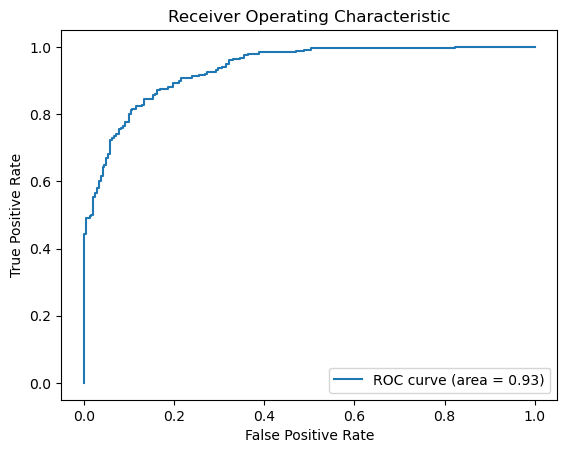

AUC: 0.93
Test Log Loss: 0.3255
Matthews Correlation Coefficient: 0.71


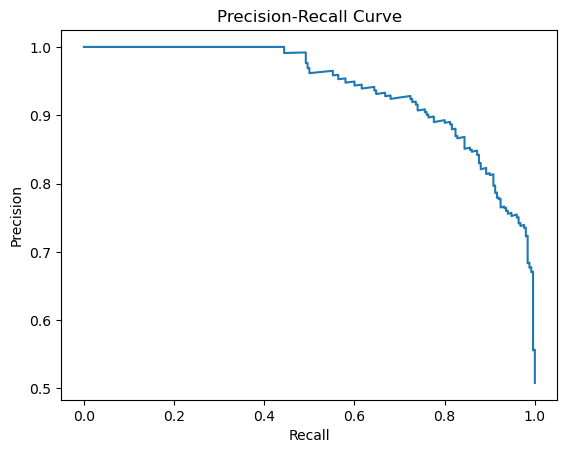

              precision    recall  f1-score   support

        Loss       0.83      0.88      0.86       242
         Win       0.88      0.82      0.85       250

    accuracy                           0.85       492
   macro avg       0.85      0.85      0.85       492
weighted avg       0.86      0.85      0.85       492



In [60]:
from sklearn.metrics import precision_score, recall_score

# Convert tensors to NumPy arrays
y_test_np = y_test_tensor.numpy()
predicted_np = predicted.numpy()

precision = precision_score(y_test_np, predicted_np)
recall = recall_score(y_test_np, predicted_np)

print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
from sklearn.metrics import f1_score

f1 = f1_score(y_test_np, predicted_np)
print(f'F1-Score: {f1:.2f}')
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_test_np, predicted_np)
print(conf_matrix)
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Get predicted probabilities
probs = test_outputs.numpy()

# Calculate ROC curve and AUC score
fpr, tpr, _ = roc_curve(y_test_np, probs)
auc = roc_auc_score(y_test_np, probs)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {auc:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

print(f'AUC: {auc:.2f}')
criterion = nn.BCELoss()
test_loss = criterion(test_outputs, y_test_tensor)
print(f'Test Log Loss: {test_loss.item():.4f}')
from sklearn.metrics import matthews_corrcoef

mcc = matthews_corrcoef(y_test_np, predicted_np)
print(f'Matthews Correlation Coefficient: {mcc:.2f}')

from sklearn.metrics import precision_recall_curve

precision, recall, _ = precision_recall_curve(y_test_np, probs)

plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()
from sklearn.metrics import classification_report

print(classification_report(y_test_np, predicted_np, target_names=['Loss', 'Win']))


In [57]:
from skorch import NeuralNetBinaryClassifier
from sklearn.model_selection import cross_val_score

# Wrap your PyTorch model
net = NeuralNetBinaryClassifier(
    SimpleNN,
    module__input_size=X_train.shape[1],
    max_epochs=100,
    lr=0.01,
    optimizer=optim.Adam,
    criterion=nn.BCELoss,
    iterator_train__shuffle=True,
    verbose=0
)

# Perform cross-validation
accuracies = cross_val_score(net, X_train.values.astype('float32'), y_train.values.astype('float32'), cv=5, scoring='accuracy')

print(f'Cross-Validation Accuracy: {accuracies.mean() * 100:.2f}%')


Cross-Validation Accuracy: 78.69%


In [68]:

from sklearn.metrics import accuracy_score

def permutation_feature_importance(model, X_test, y_test, metric=accuracy_score):
    # Get the baseline performance
    model.eval()
    with torch.no_grad():
        baseline_preds = (model(torch.FloatTensor(X_test)) >= 0.5).float().numpy()
        baseline_performance = metric(y_test, baseline_preds)

    importances = []
    for col in range(X_test.shape[1]):
,  # Shuffle one feature column at a time
        X_test_permuted = X_test.copy()
        np.random.shuffle(X_test_permuted[:, col])
        
        # Evaluate the model with the permuted feature
        with torch.no_grad():
            permuted_preds = (model(torch.FloatTensor(X_test_permuted)) >= 0.5).float().numpy()
            permuted_performance = metric(y_test, permuted_preds)
        
        # The importance is the performance decrease
        importance = baseline_performance - permuted_performance
        importances.append(importance)
    
    return np.array(importances)

# Call this function with validation data
importances = permutation_feature_importance(model, X_test_tensor.numpy(), y_test_tensor.numpy())

# Print feature importances
for i, importance in enumerate(importances):
    print(f"Feature {i}: Importance {importance}")


Feature 0: Importance 0.0
Feature 1: Importance 0.19512195121951215
Feature 2: Importance 0.05691056910569103
Feature 3: Importance 0.12398373983739841
Feature 4: Importance 0.0060975609756097615
Feature 5: Importance 0.0
Feature 6: Importance 0.05487804878048774
Feature 7: Importance 0.1565040650406504
Feature 8: Importance 0.0
Feature 9: Importance 0.04268292682926822
Feature 10: Importance 0.004065040650406471
Feature 11: Importance 0.010162601626016232
Feature 12: Importance 0.03252032520325199
Feature 13: Importance 0.004065040650406471
Feature 14: Importance 0.00203252032520318


In [62]:
# Get the weights of the first layer
fc1_weights = model.fc1.weight.data

# Convert to absolute values to get the magnitude of the weights
importance_weights = torch.abs(fc1_weights).mean(dim=0).numpy()

# Print feature importance by the weights
for i, importance in enumerate(importance_weights):
    print(f"Feature {i}: Importance {importance}")


Feature 0: Importance 0.11698214709758759
Feature 1: Importance 0.13411036133766174
Feature 2: Importance 0.1509282886981964
Feature 3: Importance 0.13114339113235474
Feature 4: Importance 0.13072073459625244
Feature 5: Importance 0.1644437313079834
Feature 6: Importance 0.17690689861774445
Feature 7: Importance 0.14875701069831848
Feature 8: Importance 0.16237960755825043
Feature 9: Importance 0.1392674595117569
Feature 10: Importance 0.1493293046951294
Feature 11: Importance 0.14526201784610748
Feature 12: Importance 0.16363224387168884
Feature 13: Importance 0.13586321473121643
Feature 14: Importance 0.14183391630649567


In [84]:
# manual_entry = [0, 140, 0.0, 0.3, 0.1, 0.0, 0.2, 0.4, 0.0, 0.3, 0.05, 0.1, 0.25, 0.0, 0.15]
# manual_entry = [0,135,5,10,25,0.212,30,97,0.6,5,0.813,17,3,3,20]
manual_entry = [1,135, 11, 47, 34, 0.412,15, 97,0.557,16,0.813,17, 6, 6,38]
# Convert the list to a numpy array and then to a PyTorch tensor
input_tensor = torch.FloatTensor(manual_entry).reshape(1, -1)

# Make the prediction
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Disable gradient calculation
    prediction = model(input_tensor)

# If your model outputs a probability for binary classification, apply a sigmoid
if prediction.size(1) == 1:  # Assuming binary classification with a single output node
    prediction = torch.sigmoid(prediction)

# Convert prediction to numpy for easier interpretation
prediction_value = prediction.numpy()

print(f"Prediction for manually created entry: {prediction_value}")

Prediction for manually created entry: [[0.73065925]]


In [87]:
exDF[exDF['PTS'].isin([135])]

,TEAM_NAME,HA,WL,FGA,FG_PCT,FG3A,FG3_PCT,FTA,FT_PCT,OREB,DREB,AST,STL,BLK,TOV,PF,PTS
531,San Antonio Spurs,1,0,89,0.539,41,0.439,23,0.913,11,36,34,4,7,21,22,135
689,Toronto Raptors,1,1,87,0.575,34,0.529,24,0.708,9,38,39,3,9,15,18,135
741,Philadelphia 76ers,0,1,88,0.602,31,0.452,17,0.882,5,40,30,10,6,10,17,135
777,Cleveland Cavaliers,1,1,97,0.485,48,0.396,34,0.647,14,24,29,7,8,12,25,135
998,Orlando Magic,0,0,90,0.489,44,0.568,27,0.815,7,32,33,10,7,21,30,135
1038,Sacramento Kings,1,1,100,0.52,38,0.553,15,0.667,11,31,35,4,1,15,23,135
1114,Milwaukee Bucks,1,1,92,0.565,42,0.429,16,0.813,12,42,34,3,6,11,22,135
1122,San Antonio Spurs,1,1,87,0.517,38,0.474,34,0.794,7,38,31,9,7,15,20,135
1213,Cleveland Cavaliers,1,1,93,0.591,28,0.429,19,0.684,11,44,36,5,3,11,9,135
1250,Detroit Pistons,1,0,94,0.468,37,0.568,32,0.813,9,31,30,6,2,9,30,135


In [100]:
# Correct way to filter for rows where PTS equals 135
filtered_df = exDF[exDF['PTS'] == 135]
print(filtered_df)

                  TEAM_NAME HA WL  FGA FG_PCT FG3A FG3_PCT FTA FT_PCT OREB  \
531       San Antonio Spurs  1  0   89  0.539   41   0.439  23  0.913   11   
689         Toronto Raptors  1  1   87  0.575   34   0.529  24  0.708    9   
741      Philadelphia 76ers  0  1   88  0.602   31   0.452  17  0.882    5   
777     Cleveland Cavaliers  1  1   97  0.485   48   0.396  34  0.647   14   
998           Orlando Magic  0  0   90  0.489   44   0.568  27  0.815    7   
1038       Sacramento Kings  1  1  100   0.52   38   0.553  15  0.667   11   
1114        Milwaukee Bucks  1  1   92  0.565   42   0.429  16  0.813   12   
1122      San Antonio Spurs  1  1   87  0.517   38   0.474  34  0.794    7   
1213    Cleveland Cavaliers  1  1   93  0.591   28   0.429  19  0.684   11   
1250        Detroit Pistons  1  0   94  0.468   37   0.568  32  0.813    9   
1383        Houston Rockets  1  1   98  0.531   36   0.333  25   0.76   14   
1439        Houston Rockets  1  1   93  0.591   31   0.355  17  

In [96]:
num_games_wl_1 = (filtered_df['WL'] == 1).sum()
print('The number of games where a team scored exactly 135 is ', len(filtered_df))
print("Number of games where WL is 1:", num_games_wl_1, '\n'+'This is at a rate of', num_games_wl_1/len(filtered_df))

The number of games where a team scored exactly 135 is  19
Number of games where WL is 1: 16 
This is at a rate of 0.8421052631578947


In [97]:
num_games_ha_1 = (filtered_df['HA'] == 1).sum()
print("Number of home teams that scored 135:", num_games_ha_1, '\n'+'This is at a rate of', num_games_ha_1/len(filtered_df))

Number of home teams that scored 135: 15 
This is at a rate of 0.7894736842105263


In [98]:
winningHome135 = filtered_df[(filtered_df['WL']==1) & (filtered_df['HA']==1)]
print(len(winningHome135))
print('Of the Home Teams that scored 135 points', len(winningHome135), 'out of', num_games_ha_1,'won. That is a rate of', len(winningHome135)/num_games_ha_1)

13
Of the Home Teams that scored 135 points 13 out of 15 won. That is a rate of 0.8666666666666667


In [102]:
newfiltered_df = exDF[exDF['PTS'] > 135]
print(newfiltered_df)

                  TEAM_NAME HA WL  FGA FG_PCT FG3A FG3_PCT FTA FT_PCT OREB  \
26           Indiana Pacers  1  1  107  0.523   43   0.465  12  0.917   10   
124          Boston Celtics  1  1   95  0.568   35   0.571  28  0.964   11   
147   Golden State Warriors  0  1   92  0.533   40    0.45  30  0.833   13   
148   Oklahoma City Thunder  1  0   83  0.602   29   0.517  30    0.8    7   
182      Philadelphia 76ers  1  1   91   0.56   31   0.387  36  0.889   10   
...                     ... .. ..  ...    ...  ...     ...  ..    ...  ...   
2313         Denver Nuggets  1  1   88  0.602   41   0.561  16  0.813    6   
2342       Dallas Mavericks  1  1   85  0.541   39   0.385  45  0.889    6   
2343        Houston Rockets  0  0   93  0.495   41   0.415  35  0.771    4   
2366         Indiana Pacers  0  1   99  0.545   45   0.356  23  0.696   15   
2450         Indiana Pacers  1  1  100   0.65   36   0.528  10    0.8   12   

     DREB AST STL BLK TOV  PF  PTS  
26     41  38  10   8  12 

In [104]:
newfilterfiltered_df = exDF[(exDF['PTS'] > 135) & (exDF['WL'] == 1)]
print(newfilterfiltered_df)

                  TEAM_NAME HA WL  FGA FG_PCT FG3A FG3_PCT FTA FT_PCT OREB  \
26           Indiana Pacers  1  1  107  0.523   43   0.465  12  0.917   10   
124          Boston Celtics  1  1   95  0.568   35   0.571  28  0.964   11   
147   Golden State Warriors  0  1   92  0.533   40    0.45  30  0.833   13   
182      Philadelphia 76ers  1  1   91   0.56   31   0.387  36  0.889   10   
205          Indiana Pacers  1  1   95  0.579   38   0.526  23  0.957    9   
...                     ... .. ..  ...    ...  ...     ...  ..    ...  ...   
2190             Miami Heat  1  1   92  0.587   39   0.538  18  0.722    6   
2313         Denver Nuggets  1  1   88  0.602   41   0.561  16  0.813    6   
2342       Dallas Mavericks  1  1   85  0.541   39   0.385  45  0.889    6   
2366         Indiana Pacers  0  1   99  0.545   45   0.356  23  0.696   15   
2450         Indiana Pacers  1  1  100   0.65   36   0.528  10    0.8   12   

     DREB AST STL BLK TOV  PF  PTS  
26     41  38  10   8  12 

In [105]:
106/120

0.8833333333333333

These results show that the points stat (after a certain threshold) can be the primary feature considered when predicting a Win. What if we consider values in the range of 100-120 or below 100? Does this mean our other features would have more influence in our predictions then? Are these conclusions confirmed with our permutation feature importance? Both PTS and FGA dominate the other features.